<h1 style="color:#FF0000">Set-up</h1>



### Import libraries
- Imports libraries needed for this notebook

In [20]:
pip install chart_studio

In [21]:
import pandas as pd
from datetime import datetime as dt
import urllib.request
import json
import yfinance as yf
import time
from tqdm import tqdm
from requests.exceptions import HTTPError, RequestException
import plotly.express as px

In [22]:
# Import and setup for plotly in Colab
import chart_studio
import chart_studio.plotly as py # for plotting graphs
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

# Enable displaying pandas data frames as interactive tables by default
from google.colab import data_table # so tables don't suck
data_table.enable_dataframe_formatter()

- Pick your start and end dates, <br>
- whether you want the peer data or the company data,<br>
- and what threshold you want for percentage presence over time of each company's stock within an index <br>
- choose your file <br>
- and your index <br>
- download_lag is the pause in seconds between evaluating each ticker, i recommend 0.5 to prevent yahoo throttling your access

In [23]:
start ='2014-01-01' #@param {type:string} ['2014-01-01','2019-12-01']
end = 'today' #@param {type:string} ['2019-11-01','today']
benchmark= False #@param {type:'boolean'}
threshold=90 #@param {type:'integer'}
chosen_ticker_file = 'S&P500tickers.csv' #@param {type:string} ['S&P500tickers.csv','FTSE250tickers.csv']
fin_index= 'SP500' #@param {type:string} ['SP500','FTSE250']
download_lag= 0.5 #@param


if end == 'today':
  end = None
# when slicing with None it goes right up to the end of the dataframe

#create time variable to name dataset
if start == '2014-01-01':
  if end==None:
    time_range='all'
  elif end=='2019-11-01':
    time_range='before'
else:
    time_range='after'

#create data variable to name dataset
if benchmark==True:
    datatype='peerGroup'
else:
    datatype='ticker'

<h1 style="color:#FF0000">Tickers list</h1>

### Create tickers list function
- Takes a CSV for an index fund with a list of dates, each with a corresponding list of tickers that were in an index on that date
- Also takes a threshold percentage time (out of 100) that a stock has to have been on the index (default 90)
- Returns a list of tickers which have been on that index a specified percentage of the time between 2014 and 2025

In [24]:
# code I borrowed from: https://medium.com/@rganesh0203/different-ways-to-count-duplicates-in-list-python-in-worst-to-best-complexities-8a23c3ebd9c4
# this code just counts how many times an element occurs in a list and puts that in a dictionary with key as element and value as number of occurences
def count_duplicates_dict(lst):
        duplicates = {}
        for item in lst:
            if item in duplicates:
                duplicates[item] += 1
            else:
                duplicates[item] = 1
        return {key: value for key, value in duplicates.items() if value > 1}

In [25]:
def tickers_func(file, threshold=90):
    strongest=[]      #creates an empty list
    df=pd.read_csv(file)      #read csv file

    df['date']=pd.to_datetime(df['date'])      #set date column as datetime object
    df=df[df['date']>'2014-01-01']      #we only want data pre 2014
    df_list=list(df['tickers'])      #create a list, each element is a string that contains all the stock tickers for that date
    total=len(df_list)      #gets total number of timestamp rows

    for index,value in enumerate(df_list):      #iterates through df_list
        strongest.extend(value.split(','))      #splits the strings of tickers into lists of strings of single tickers and adds all those lists into one big list
    dict_best_tickers=count_duplicates_dict(strongest)      #uses the count duplicates function to count how many times a ticker shows up in the list

    for i in dict_best_tickers:      #iterates through dictionary and replaces count of occurences with percentage of occurences
        dict_best_tickers[i]=round(100*dict_best_tickers[i]/total,2)
    sorted_dict = dict(sorted(dict_best_tickers.items(), key=lambda item: item[1],reverse=True))      #sorts by percentage of occurences

    final_dict=dict()      #create empty dictionary

    for i in sorted_dict:      #iterate through dictionary, adding values which exceed the occurence threshold to the empty dictionary
        if sorted_dict[i]>=threshold:
            final_dict[i]=sorted_dict[i]

    tickers=list(final_dict.keys())      #gets the keys i.e. tickers of the dictionary and puts them in a list

    return tickers      #exports the list



```
# This is formatted as code
```

### S&P 500 tickers list

In [26]:
df=pd.read_csv('SP')

FileNotFoundError: [Errno 2] No such file or directory: 'SP'

### These will need to be changed if the index is changed (has been done manually)

In [27]:
tickers=tickers_func(chosen_ticker_file, threshold=threshold)      #calls the function above

In [28]:
len(tickers)

370

In [29]:
# used claude anthropic to sort failing tickers into tickers to change and tickers to remove
if chosen_ticker_file=='S&P500tickers.csv':
  change_dict= {
        'FB': 'META',
        'ANTM': 'ELV',   #updated tickers
        'BLL': 'BALL',
        'DISCA': 'WBD',
        'CTL': 'LUMN',
        'MYL': 'VTRS',
        'FISV': 'FI',
        'COG': 'CTRA',
        'BF.B':'BF-B',
        'BRK.B':'BRK-B'}



  remove_list =[
          'A',
          'NLSN',
          'CERN',
          'XLNX',
          'KSU',
          'ALXN',  #comapanies that have gone private or don't have data
          'VAR',
          'TIF',
          'NBL',
          'ETFC',
          'ADS',
          'AGN',
          'FLIR',
          'GPS',
          'MRO',
          'PXD',
          'PKI',
          'CTXS',
          'PBCT',
          'ABC',
          'GOOG']
  for _index, _value in change_dict.items():
    tickers[tickers.index(_index)]=_value
  for _value in remove_list:
    tickers.remove(_value)

In [ ]:
# x='''
# PXD
# ABC
# FISV
# PKI
# NLSN
# CTXS
# ANTM
# FB
# CERN
# BLL
# DISCA
# PBCT
# XLNX
# GPS
# KSU
# COG
# ALXN
# VAR
# TIF
# MYL
# NBL
# ETFC
# CTL
# ADS
# AGN'''.split()
# for i in remove_list:
#  if i not in remove_list:
#     print(i)


In [30]:
len(tickers),len(remove_list),len(tickers)+len(remove_list)

(349, 21, 370)

In [31]:
# import yfinance as yf
# remove_list =[
#           'A',
#           'NLSN',
#           'CERN',
#           'XLNX',
#           'KSU',
#           'ALXN',  #comapanies that have gone private or don't have data
#           'VAR',
#           'TIF',
#           'NBL',
#           'ETFC',
#           'ADS',
#           'AGN',
#           'FLIR',
#           'GPS',
#           'MRO',
#           'PXD',
#           'PKI',
#           'CTXS',
#           'PBCT',
#           'ABC',
#           'GOOG']
# for i in remove_list:
#   print(i)
#   print(yf.Ticker(i).history('1d'))

<h1 style="color:#FF0000">Getting tables of historical ESG data using tickers list</h1>

### Define esg score function
- This function takes 1 ticker e.g. 'AAPL', and start/end dates in a yyyy-mm-dd format
- Then returns 2 things:
- Firstly a dataframe with ESG, E, S and G scores over time
- Secondly a dictionary with tickers as keys and percentage of values ffilled as values
- When benchmark = True this function is exactly the same except it gives ESG/E/S/G data for the peergroup of tickers, acting as a benchmark score for that ticker, the benchmark group is found in yf.Ticker('E.g. AAPL').sustainability['peerGroup'] or by scraping the same url as below

-  adapted from code by jrpars1 on: https://stackoverflow.com/questions/75957370/invalid-synthax-in-df-while-fetching-esg-data-from-yahoo-finance

In [32]:
def esg_score_func(ticker,start=None,end=None,benchmark=False):      #ticker string, start date, end date (both as yyyy-mm-dd)

    url = f"https://query2.finance.yahoo.com/v1/finance/esgChart?symbol={ticker}"      #url for get request
    connection = urllib.request.urlopen(url)      #perform get request

    data = connection.read()      #read request
    data_source = json.loads(data)      #loads as a json

    if benchmark==False:
        data = data_source["esgChart"]["result"][0]["symbolSeries"]                      #unpacks json
        m=ticker

    else:
        data = data_source["esgChart"]["result"][0]['peerSeries']                   #if benchmark = True returns sector scores for peerGroup to use for benchmarking
        m = data_source['esgChart']['result'][0]['peerGroup']


    data = pd.DataFrame(data)      #turns it into dataframe              #if benchmark = False returns ticker scores
    data.rename(columns={'esgScore':'esgScore'+ m,'governanceScore':'governanceScore' + m, 'environmentScore':'environmentScore'+ m,'socialScore':'socialScore'+ m}, inplace=True)
    data["timestamp"] = pd.to_datetime(data["timestamp"], unit="s")      #change dtype of timestamp to datetime object
    data.set_index('timestamp',drop=True,inplace=True)      #turns timestamp column to index

    data=data.loc[start:end]      #cuts down dataframe to data between the start and end dates
    # data.ffill(inplace=True)      #forwardfills missing data


    return(data)

### EITHER: Create historical ESG table for list of companies (benchmark=False)

- merges all the ESG and E/S/G values for each ticker to a master table
- master table has time index created in previous cell i.e. the rows represent time
- each merge on master table adds four columns each with the four scores of a specific ticker e.g. esg_aapl,e_aapl,s_aapl,g_aapl
- Creates ESG_table and na_dict

### OR: Create historical ESG data for peer_group of companies (benchmark =True)

- Create similar ESG|E/S/G tables but the scores are for the peerGroup of the ticker not the ticker itself
- We can use these to benchmark tickers compared to their own sector and measure peerGroup performance
- Code is exactly the same but we use esg_score_func(benchmark=True) instead
- Creates ESG_peer_table (the variables won't mention peer but the dataset would)

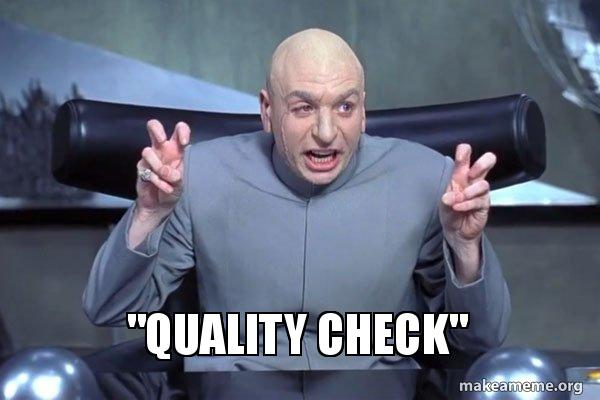

# -
# don't forget to deactivate ffill() in esg_score_func() first!!!!!!!!!!!!!!!!
# don't forget to set time-range to all

In [33]:
tickers=['STX', 'BLK', 'USB', 'LB']

In [34]:
c=0
list_failed=[]
list_small= [] #checks all the tickers and returns the small/failed/gappy esg historical datasets
list_gaps=[]
list_ends=[]
small=20 #@param {type:'integer'} #choose how many rows is small
data_test=[]
max_gap=13 #@param {type:'integer'} #choose how many rows is small
for i in tqdm(range(0,len(tickers))):
  time.sleep(download_lag)
  try:
    data_test=esg_score_func(tickers[i],start=start,end=end,benchmark=benchmark) #sets up initial dataframe

    if len(data_test.dropna().loc[:'2015-01-01'])==0 or len(data_test.dropna().loc['2024-01-01':])==0:
      print('missing start or end',tickers[i],data_test.head(),data_test.tail())
      list_ends.extend([tickers[i]])
      c+=1
      print('------------------------------------------------------')

    elif data_test.bfill(limit=max_gap).isnull().sum().iloc[0]>0 or data_test.ffill(limit=max_gap).isnull().sum().iloc[0]>0:
      print('gaps',tickers[i],data_test[data_test.ffill(limit=max_gap).isnull().any(axis=1)],data_test[data_test.bfill(limit=max_gap).isnull().any(axis=1)])
      list_gaps.extend([tickers[i]])
      c+=1
      print('------------------------------------------------------')

    elif len(data_test.dropna().loc['2019-11-01' :])<small or len(data_test.loc[:'2019-11-01'])<small:
      print('small',tickers[i],data_test,'size =',data_test.shape)
      list_small.extend([tickers[i]])
      c+=1
      print('------------------------------------------------------')

  except Exception as error:
    print('failed',tickers[i],error)
    c+=1
    list_failed.extend([tickers[i]])
    print('------------------------------------------------------')
print('total problems=',c)
display('failed:',list_failed,'missing start/end:',list_ends,'gaps:',list_gaps,'small:',list_small)

 25%|██▌       | 1/4 [00:00<00:01,  1.58it/s]

gaps STX             esgScoreSTX  governanceScoreSTX  environmentScoreSTX  \
timestamp                                                          
2022-07-01          NaN                 NaN                  NaN   
2022-08-01          NaN                 NaN                  NaN   
2022-09-01          NaN                 NaN                  NaN   
2022-10-01          NaN                 NaN                  NaN   
2022-11-01          NaN                 NaN                  NaN   
2022-12-01          NaN                 NaN                  NaN   
2023-01-01          NaN                 NaN                  NaN   
2023-02-01          NaN                 NaN                  NaN   
2023-03-01          NaN                 NaN                  NaN   
2023-04-01          NaN                 NaN                  NaN   
2023-05-01          NaN                 NaN                  NaN   
2023-06-01          NaN                 NaN                  NaN   
2023-07-01          NaN                

 50%|█████     | 2/4 [00:01<00:01,  1.65it/s]

missing start or end BLK             esgScoreBLK  governanceScoreBLK  environmentScoreBLK  \
timestamp                                                          
2014-09-01         61.0                66.0                 62.0   
2014-10-01         61.0                66.0                 62.0   
2014-11-01         61.0                66.0                 62.0   
2014-12-01         61.0                66.0                 62.0   
2015-01-01         62.0                67.0                 63.0   

            socialScoreBLK  
timestamp                   
2014-09-01            54.0  
2014-10-01            54.0  
2014-11-01            54.0  
2014-12-01            54.0  
2015-01-01            54.0               esgScoreBLK  governanceScoreBLK  environmentScoreBLK  \
timestamp                                                          
2023-05-01          NaN                 NaN                  NaN   
2023-06-01          NaN                 NaN                  NaN   
2023-07-01          NaN

 75%|███████▌  | 3/4 [00:01<00:00,  1.69it/s]

missing start or end USB             esgScoreUSB  governanceScoreUSB  environmentScoreUSB  \
timestamp                                                          
2014-09-01         57.0                50.0                 56.0   
2014-10-01         57.0                50.0                 56.0   
2014-11-01         57.0                50.0                 56.0   
2014-12-01         57.0                50.0                 56.0   
2015-01-01         62.0                55.0                 62.0   

            socialScoreUSB  
timestamp                   
2014-09-01            64.0  
2014-10-01            64.0  
2014-11-01            64.0  
2014-12-01            64.0  
2015-01-01            68.0               esgScoreUSB  governanceScoreUSB  environmentScoreUSB  \
timestamp                                                          
2020-06-01          NaN                 NaN                  NaN   
2020-07-01        27.04               12.45                 1.39   
2020-08-01        27.04

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

missing start or end LB             esgScoreLB  governanceScoreLB  environmentScoreLB  socialScoreLB
timestamp                                                                   
2014-09-01        64.0               68.0                61.0           64.0
2014-10-01        64.0               68.0                61.0           64.0
2014-11-01        64.0               68.0                61.0           64.0
2014-12-01        64.0               68.0                61.0           64.0
2015-01-01        64.0               68.0                61.0           64.0             esgScoreLB  governanceScoreLB  environmentScoreLB  socialScoreLB
timestamp                                                                   
2021-01-01       16.72               6.46                2.48           7.78
2021-02-01       16.12               5.87                2.48           7.78
2021-03-01       16.12               5.87                2.48           7.78
2021-04-01         NaN                NaN           

'failed:'

[]

'missing start/end:'

['BLK', 'USB', 'LB']

'gaps:'

['STX']

'small:'

[]

# don't forget to reactivate ffill() in esg_score_func() first!!!!!!!!!!!!!!!!!/ don't forget to set time-range back

In [ ]:
# iterates through all tickers in ticker list
# merges all the ESG and E/S/G values for each ticker to a master table
# master table has time index created in previous cell i.e. the rows represent time
# each merge on master table adds four columns each with the four scores of a specific ticker


esg_=esg_score_func(tickers[0],start=start,end=end,benchmark=benchmark) #sets up initial dataframe
ESG_table=esg_


for ticker in tqdm(tickers[1:]):      #tqdm gives a progress bar for iterations, we're iterating through tickers list

    time.sleep(download_lag)      #this stops me from getting banned from using yahoo finance by limiting request rate with a pause


    esg_=esg_score_func(ticker,start=start,end=end,benchmark=benchmark)      #get esg data for each ticker for pre-2019
    ESG_table=ESG_table.merge(esg_,how='outer',suffixes=('','_extra'),left_index=True,right_index=True)      #merge ticker esg data onto master table

100%|██████████| 348/348 [06:40<00:00,  1.15s/it]


In [ ]:
ESG_table.tail(15)

,esgScoreAAPL,governanceScoreAAPL,environmentScoreAAPL,socialScoreAAPL,esgScoreABBV,governanceScoreABBV,environmentScoreABBV,socialScoreABBV,esgScoreABT,governanceScoreABT,...,environmentScoreHOG,socialScoreHOG,esgScoreJWN,governanceScoreJWN,environmentScoreJWN,socialScoreJWN,esgScoreHP,governanceScoreHP,environmentScoreHP,socialScoreHP
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-11-01,17.22,9.37,0.46,7.39,29.93,10.36,2.38,17.19,24.83,8.33,...,2.86,6.00,20.30,3.88,3.66,12.75,22.31,0.0,0.0,0.0
2023-12-01,17.22,9.37,0.46,7.39,29.93,10.36,2.38,17.19,24.83,8.33,...,2.86,6.00,20.30,3.88,3.66,12.75,22.31,0.0,0.0,0.0
2024-01-01,17.22,9.37,0.46,7.39,29.93,10.36,2.38,17.19,24.83,8.33,...,2.86,6.00,20.30,3.88,3.66,12.75,22.31,0.0,0.0,0.0
2024-02-01,17.22,9.37,0.46,7.39,29.93,10.36,2.38,17.19,24.83,8.33,...,2.86,6.00,20.30,3.88,3.66,12.75,22.31,0.0,0.0,0.0
2024-03-01,17.22,9.37,0.46,7.39,29.93,10.36,2.38,17.19,24.83,8.33,...,2.86,6.00,20.30,3.88,3.66,12.75,22.31,0.0,0.0,0.0
2024-04-01,17.22,9.37,0.46,7.39,29.93,10.36,2.38,17.19,24.83,8.33,...,2.86,6.00,20.30,3.88,3.66,12.75,22.31,0.0,0.0,0.0
2024-05-01,17.22,9.37,0.46,7.39,29.93,10.36,2.38,17.19,24.83,8.33,...,2.86,6.00,20.30,3.88,3.66,12.75,22.31,0.0,0.0,0.0
2024-06-01,17.22,9.37,0.46,7.39,29.93,10.36,2.38,17.19,24.83,8.33,...,2.86,6.00,20.30,3.88,3.66,12.75,22.31,0.0,0.0,0.0
2024-07-01,17.22,9.37,0.46,7.39,29.93,10.36,2.38,17.19,24.83,8.33,...,2.86,6.00,20.30,3.88,3.66,12.75,22.31,0.0,0.0,0.0


In [ ]:
c=0
for i in ESG_table.columns: #drops duplicate columns
    if '_extra' in i:
        try:
            ESG_table=ESG_table.drop(i,axis=1)
        except:
            c+=1
print(c)

if time_range=='after': #smooths esg_rating type transistion
    ESG_table.loc['2019-12-01']=ESG_table.loc['2020-01-01']
else:
    pass

0


# Cleaning data

In [ ]:
# ESG_table=ESG_table
# E_table=ESG_table.filter(like='environment')
# S_table=ESG_table.filter(like='social')
# G_table=ESG_table.filter(like='governance')
# just_esg_table=ESG_table.filter(like='esg')

In [ ]:
iterdict={'ESG_table':ESG_table}
iterdict.values()

dict_values([            esgScoreAAPL  governanceScoreAAPL  environmentScoreAAPL  \
timestamp                                                             
2019-12-01         23.82                10.26                  0.55   
2020-01-01         23.82                10.26                  0.55   
2020-02-01         23.82                10.26                  0.55   
2020-03-01         23.82                10.26                  0.55   
2020-04-01         23.82                10.26                  0.55   
...                  ...                  ...                   ...   
2024-09-01         17.22                 9.37                  0.46   
2024-10-01         16.79                 8.72                  0.55   
2024-11-01         16.79                 8.72                  0.55   
2024-12-01         16.79                 8.72                  0.55   
2025-01-01         16.79                 8.72                  0.55   

            socialScoreAAPL  esgScoreABBV  governanceScoreABBV 

<h1 style="color:#FF0000">Upload to GBQ</h1>

In [ ]:
from google.colab import auth #authenticates google colab
auth.authenticate_user()

In [ ]:
#@title access BigQuery project
project_id = 'lw-esg-project'

# Package used for interfacing w/ BigQuery from Python
from google.cloud import bigquery

# Create BigQuery client
bq_client = bigquery.Client(project = project_id)

I viciously raided this google colab notebook for code: https://colab.research.google.com/drive/1hSI1BXyCyj7viRpp1GFZqkU1qtBUd0g1?authuser=0 (produced for google by Alok Pattani I believe...)

Select the dataset, only one atm
Select output_table_id (chooses which df to upload to a table)
Select replace or append
The way I've written this that should be all you need to do

# DO NOT - I REPEAT - DO NOT: USE THIS WITHOUT CHECKING WITH AT LEAST ONE OTHER PERSON, this code can and will rewrite any work we do on bigquery (which is why it's commented out)

In [ ]:
#@title upload dataframe to BigQuery Table

output_dataset_id = 'SP500_esg' #@param{type:'string'}

output_table_id = 'ESG_table' #@param{type:'string'}

replace_or_append_output = 'replace' #@param{type:'string'} ['replace', 'append']


output_table = ESG_table



output_table_id = f"{output_table_id}_{time_range}_{datatype}"
output_table_id = f"{output_table_id}_{fin_index}_thresh{threshold}"



# Combine project and dataset
project_dataset = f"{bq_client.project}.{output_dataset_id}"

# Combine project, dataset, and table
project_dataset_table = f"{project_dataset}.{output_table_id}"

# Check to make sure output dataset exists, create it if not
try:
  bq_client.get_dataset(output_dataset_id)
  print(f"BigQuery dataset {project_dataset} exists\n")

except:
  print(f"BigQuery dataset {project_dataset} doesn't exist, so creating it\n")
  dataset = bq_client.create_dataset(bigquery.Dataset(project_dataset))

job_config = bigquery.LoadJobConfig()

# Modify job config depending on if we want to replace or append to table
if(replace_or_append_output == 'replace'):
  job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE
else:
  job_config.write_disposition = bigquery.WriteDisposition.WRITE_APPEND

dataset_ref = bq_client.dataset(output_dataset_id)
table_ref = dataset_ref.table(output_table_id)


# Use client functionality to load BigQuery table from Pandas data frame
bq_client.load_table_from_dataframe(
  dataframe = output_table,
  destination = table_ref,
  job_config = job_config
  ).result()

print((f"{output_table_id} ({replace_or_append_output}) to "
  f"BigQuery table {project_dataset_table}\n"))

BigQuery dataset lw-esg-project.SP500_esg exists

ESG_table_after_ticker_SP500_thresh90 (replace) to BigQuery table lw-esg-project.SP500_esg.ESG_table_after_ticker_SP500_thresh90



BigQuery dataset lw-esg-project.yfinance exists

ESG_table_after_peerGroup_SP500_thresh90 (replace) to BigQuery table lw-esg-project.yfinance.ESG_table_after_peerGroup_SP500_thresh90

BigQuery dataset lw-esg-project.yfinance exists

E_table_after_peerGroup_SP500_thresh90 (replace) to BigQuery table lw-esg-project.yfinance.E_table_after_peerGroup_SP500_thresh90

BigQuery dataset lw-esg-project.yfinance exists

S_table_after_peerGroup_SP500_thresh90 (replace) to BigQuery table lw-esg-project.yfinance.S_table_after_peerGroup_SP500_thresh90

BigQuery dataset lw-esg-project.yfinance exists

G_table_after_peerGroup_SP500_thresh90 (replace) to BigQuery table lw-esg-project.yfinance.G_table_after_peerGroup_SP500_thresh90

BigQuery dataset lw-esg-project.yfinance exists

just_esg_table_after_peerGroup_SP500_thresh90 (replace) to BigQuery table lw-esg-project.yfinance.just_esg_table_after_peerGroup_SP500_thresh90

